In [69]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from matplotlib.ticker import FormatStrFormatter
sns.set()

In [2]:
CN = ("CN",0.)
MCI = ("MCI",1.)
AD = ("AD",2.)

In [3]:
def str2date(string):
    """ Convert string to datetime object """
    return datetime.strptime(string, '%Y-%m-%d')

In [4]:
def VISCODE_conv(value):
    """Convert visit code to month int"""
    if isinstance(value, str):
        if value.startswith("m"):
            return int(value[1:])
        if value.startswith("bl"):
            return 0
        return int("NaN")

In [5]:
def PET_conv(value):
    '''Convert PET measures from string to float '''
    try:
        return float(value.strip().strip('>'))
    except ValueError:
        return float(np.nan)

In [6]:
def Diagnosis_conv(value):
    '''Convert diagnosis from string to float '''
    if value == 'CN':
        return CN
    if value == 'MCI':
        return MCI
    if value == 'AD':
        return AD
    return float('NaN')

In [7]:
def DX_conv(value):
    '''Convert change in diagnosis from string to float '''
    if isinstance(value, str):
        if value.endswith('Dementia') or value.endswith('AD'):
            return 2.
        if value.endswith('MCI'):
            return 1.
        if value.endswith('CN'):
            return 0.

    return float('NaN')

In [8]:
CONVERTERS = {
    'VISCODE':VISCODE_conv,
    'CognitiveAssessmentDate': str2date,
    'ScanDate': str2date,
    'Forecast Date': str2date,
    'EXAMDATE': str2date,
    'Diagnosis': Diagnosis_conv,
    'DX': DX_conv,
    'DX_bl':DX_conv,
    'PTAU_UPENNBIOMK9_04_19_17': PET_conv,
    'TAU_UPENNBIOMK9_04_19_17': PET_conv,
    'ABETA_UPENNBIOMK9_04_19_17': PET_conv
}

In [9]:
TYPES = {
}

In [10]:
def load_data():
    data_file = "data/TADPOLE/ADNIMERGE.csv"
    merge_data = pd.read_csv(data_file, na_values="", converters=CONVERTERS)
    return merge_data

In [11]:
def make_date_col(starts, duration):
    """
    Return a list of list of dates
    The start date of each list of dates is specified by *starts*
    """
    date_range = [relativedelta(months=i) for i in range(duration)]
    ret = []
    for start in starts:
        ret.append([start + d for d in date_range])

    return ret

In [12]:
def has_data_mask(frame):
    """
    Check whether rows has any valid value (i.e. not NaN)
    Args:
        frame: Pandas data frame
    Return:
        (ndarray): boolean mask with the same number of rows as *frame*
        True implies row has at least 1 valid value
    """
    return ~frame.isnull().apply(np.all, axis=1)

In [13]:
def get_data_dict(frame, features):
    """
    From a frame of all subjects, return a dictionary of frames
    The keys are subjects' ID
    The data frames are:
        - sorted by *Month_bl* (which are integers)
        - have empty rows dropped (empty row has no value in *features* list)
    Args:
        frame (Pandas data frame): data frame of all subjects
        features (list of string): list of features
    Return:
        (Pandas data frame): prediction frame
    """
    ret = {}
    frame_ = frame.copy()
    for subj in np.unique(frame_.RID):
        subj_data = frame_[frame_.RID == subj].sort_values('VISCODE')
        subj_data = subj_data[has_data_mask(subj_data[features])]

        #subj_data = subj_data.set_index('VISCODE', drop=True)
        ret[subj] = subj_data.drop(['RID'], axis=1)
    return ret

In [14]:
def does_transition(frame, initial_state, final_state):
    """Return how many months it takes a patient to transition from initial to final; -1 if no transition """
    """Initial and final state should be encoded as: CN = 0., MCI = 1., AD = 2."""
    transition_rows = frame.loc[(frame["DX_bl"] == initial_state) &
                                (frame["DX"] == final_state)]
    if transition_rows.empty:
        return -1
    else:
        return transition_rows["VISCODE"].iloc[0]
    

In [15]:
def transition_stats(data_dict, initial_state, final_state):
    """Return dataframe containing patients who transition from initial to final state, how long until they transitioned and their total visits"""
    transitions = 0
    transition_time = 0
    columns = ["RID", "Transition_month", "Total_months", "Transition_type"]
    data = []
    for key, value in data_dict.items():        
        t = does_transition(value, initial_state[1], final_state[1])
        if t >= 0:
            nb_visits = value["VISCODE"].iloc[value.shape[0] - 1]
            data.append([key, t, nb_visits, (initial_state[0]+" to "+final_state[0])])
    return pd.DataFrame(data, columns=columns)

In [25]:
def transition_plot(data_dict):
    transitioners_mciad = transition_stats(data_dict, MCI, AD)
    transitioners_cnmci = transition_stats(data_dict, CN, MCI)
    transitioners_cnad = transition_stats(data_dict, CN, AD)
    transitioners = pd.concat([transitioners_mciad,transitioners_cnmci,transitioners_cnad])

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=(7, 6))


    # Plot the orbital period with horizontal boxes
    sns.boxplot(x="Transition_month", y="Transition_type", data=transitioners,
                whis=[0, 100], width=.6, palette="vlag")

    # Add in points to show each observation
    sns.stripplot(x="Transition_month", y="Transition_type", data=transitioners,
                  size=4, color=".3", linewidth=0)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    plt.tight_layout()
    plt.savefig("transition_times.png")


In [26]:
merge_data = load_data()
merge_data

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (18,19,20,103,104) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,0,11,ADNI1,ADNI1,2005-09-08,0.0,74.3,Male,...,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
1,3,011_S_0003,0,11,ADNI1,ADNI1,2005-09-12,2.0,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
2,3,011_S_0003,6,11,ADNI1,ADNI1,2006-03-13,2.0,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6,2019-02-14 23:58:27.0
3,3,011_S_0003,12,11,ADNI1,ADNI1,2006-09-12,2.0,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.999316,11.96720,12,12,2019-02-14 23:58:27.0
4,3,011_S_0003,24,11,ADNI1,ADNI1,2007-09-12,2.0,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,1.998630,23.93440,24,24,2019-02-14 23:58:27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13910,4384,029_S_4384,84,29,ADNI3,ADNI2,2019-04-09,0.0,62.3,Male,...,109.3,9.86,1.12969,NaN,1.06225,7.167690,85.83610,84,84,2019-04-10 04:36:05.0
13911,6703,135_S_6703,0,135,ADNI3,ADNI3,2019-04-09,NaN,62.7,Female,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0,0,2019-04-10 04:36:10.0
13912,6145,014_S_6145,12,14,ADNI3,ADNI3,2019-04-09,0.0,70.3,Female,...,NaN,NaN,NaN,NaN,NaN,1.073240,12.85250,12,12,2019-04-11 04:36:24.0
13913,6148,014_S_6148,12,14,ADNI3,ADNI3,2019-04-05,NaN,81.5,Female,...,NaN,NaN,NaN,NaN,NaN,1.081450,12.95080,12,12,2019-04-11 04:36:24.0


In [27]:
features = ["DX_bl", "DX"]
data_slice = merge_data[["RID","VISCODE","DX_bl","DX"]]
data_dict = get_data_dict(data_slice, features)
    

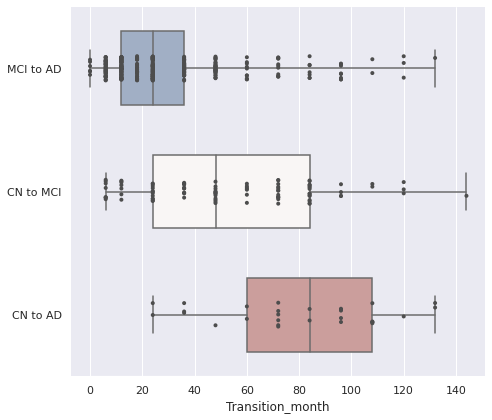

In [154]:
transition_plot(data_dict)

In [131]:
predictions = pd.read_csv("data/5_prediction.csv", index_col=0)
predictions

,RID,VISCODE,pred,DX_pred
0,2,6,0,0.0
1,2,36,0,0.0
2,2,60,0,0.0
3,2,72,0,0.0
4,2,84,0,0.0
...,...,...,...,...
8125,5292,6,0,0.0
8126,5292,24,0,0.0
8127,5294,30,0,0.0
8128,5295,24,0,0.0


In [132]:
pred_data_dict = get_data_dict(predictions, ["DX_pred"])



In [133]:
def round_to_two(x):
    new_x = x
    if x % 6 == 1:
        new_x -= 1
    elif x % 6 == 2:
        new_x -=2
    elif x % 6 == 5:
        new_x += 1  
    elif x % 6 == 4:
        new_x += 2
    return new_x
"""Finds matching sequences in true outcomes and prediction data dicts
Outputs a two arrays with each index containing corresponding outcomes and predictions"""
def create_comp_frame(pred:dict, true:dict):
    full_frame = []
    dx = []
    dx_pred = []
    for key, pred_val in pred.items():
        true_val = true[key]
        pred_val["VISCODE"] = pred_val["VISCODE"].apply(round_to_two)
        matched = pred_val.set_index("VISCODE").join(true_val.set_index("VISCODE"))
        full_frame.append(matched[["DX", "DX_pred"]])

    full_frame = pd.concat(full_frame, axis=0)
    full_frame.dropna(inplace=True)
    full_frame = full_frame.astype(int)
    return full_frame

In [162]:

def comp_n_clusters(start, end, n_folds):
    cluster_n = range(start, end+1)
    bac_all = []
    for i in range(start, end+1):
        bac = 0
        for j in range(n_folds):
            predictions = pd.read_csv("data/{}_{}_prediction.csv".format(i,j), index_col=0)
            pred_data_dict = get_data_dict(predictions, ["DX_pred"])
            comp = create_comp_frame(pred_data_dict, data_dict)
            bac += calc_balanced(comp.DX, comp.DX_pred)
            print(bac/(j+1))
        bac = bac/n_folds
        bac_all.append(bac)
    df = pd.DataFrame({"n_clusters":cluster_n, "bac":bac_all})
    return df
        

In [78]:

def comp_kmeans_similarity_bac(start, end, n_folds):
    cluster_n = range(start, end+1)
    bac_all = []
    for i in cluster_n:
        bac = 0
        for j in range(n_folds):
            predictions = pd.read_csv("data/kmeans_similarity/{}_{}_prediction.csv".format(i,j), index_col=0)
            pred = predictions["DX_pred"]
            comp = predictions["DX_true"]
            bac += calc_balanced(pred, comp)
        bac = bac/n_folds
        bac_all.append(bac)
    df = pd.DataFrame({"n_clusters":cluster_n, "bac":bac_all})
    return df

In [28]:
def calc_balanced(pred, true):
    return balanced_accuracy_score(pred, true)

In [77]:
overlap_bacs = comp_kmeans_similarity_bac(1, 15, 10)
overlap_bacs

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTra

,n_clusters,bac
0,1,0.454132
1,2,0.673342
2,3,0.776697
3,4,0.822113
4,5,0.824237
5,6,0.826061
6,7,0.826949
7,8,0.835196
8,9,0.838407
9,10,0.838769


In [79]:
bacs = comp_kmeans_similarity_bac(1, 15, 10)
bacs

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTra

,n_clusters,bac
0,1,0.453829
1,2,0.648458
2,3,0.731910
3,4,0.824427
4,5,0.824673
5,6,0.827359
6,7,0.824831
7,8,0.833313
8,9,0.838435
9,10,0.840068


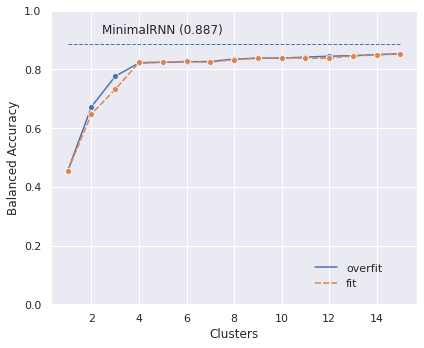

In [112]:
stats = pd.DataFrame({"overfit":overlap_bacs["bac"], "fit":bacs["bac"], "Clusters":bacs["n_clusters"], })
stats = stats.set_index("Clusters")
ax = sns.relplot(ci=None, kind="line", data=stats, marker="o");

ax.set_xticklabels(step=1)
ax.set(ylim=(0, 1))
plt.plot([1, 15], [0.887, 0.887], linewidth=1, linestyle="dashed")
label = "MinimalRNN ({:.3f})".format(0.887)
plt.annotate(label, # this is the text
                 (5,0.887), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 
ax.set_ylabels("Balanced Accuracy")
ax._legend.set_bbox_to_anchor((0.9,.2))
#plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("kmeans_similarity_bac_overfit_contrast.png")
